In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import time
from collections import Counter
import community
import operator
from networkx.algorithms.community import greedy_modularity_communities, k_clique_communities
from node2vec import Node2Vec
from scipy import spatial
plt.style.use(['dark_background'])
import warnings
warnings.filterwarnings("ignore")
import random

### Read Data

In [0]:
coreData = pd.read_csv(".../beerdatafullcondensed.csv", sep = "|")
coreData["ReviewProfileName"]=coreData["ReviewProfileName"].str.strip()
coreData["beerName"]=coreData["beerName"].str.strip().str.replace('"',"")
coreData["beerStyle"]=coreData["beerStyle"].str.strip()

Convert epoch dates to full data, year and month columns

In [0]:
coreData["RTadjusted"] = coreData["ReviewTime"].\
                    apply(lambda x: time.strftime("%d/%m/%Y", time.gmtime(x)))

coreData["RTyear"] = coreData["ReviewTime"].\
                    apply(lambda x: time.strftime("%Y", time.gmtime(x))).astype("int")

coreData["RTmonth"] = coreData["ReviewTime"].\
                    apply(lambda x: time.strftime("%m", time.gmtime(x))).astype("int")

In [0]:
print("Before Filtering")
print("Number of BeerIds:",coreData.groupby("beerId").count().shape[0])
print("Number of Reviews:",coreData.shape[0])
print("Number of Reviewers:",len(coreData["ReviewProfileName"].unique()))
print("Average Number of Reviews per BeerId:",int((coreData.groupby("beerId").count().loc[:,"ReviewProfileName"]).mean()))
print("Mean Rating:",round(coreData.groupby("beerId").mean().loc[:,"ReviewOverall"].mean(),2))
coreData.head(2)

Before Filtering
Number of BeerIds: 66055
Number of Reviews: 1586614
Number of Reviewers: 33388
Average Number of Reviews per BeerId: 24
Mean Rating: 3.66


,beerName,beerId,brewerId,beerABV,beerStyle,ReviewAppearance,ReviewAroma,ReviewPalate,ReviewTaste,ReviewOverall,ReviewTime,ReviewProfileName,RTadjusted,RTyear,RTmonth
0,Sausa Weizen,47986,10325,5.00,Hefeweizen,2.5,2.0,1.5,1.5,1.5,1234817823,stcules,16/02/2009,2009,2
1,Red Moon,48213,10325,6.20,English Strong Ale,3.0,2.5,3.0,3.0,3.0,1235915097,stcules,01/03/2009,2009,3


### Remove Spams

Remove the reviewers which reviewed beers above a threshold (spam)

In [0]:
percentage = 0.01
spamThr = int(percentage*coreData.groupby("beerId").count().shape[0])
spamfilter = coreData.groupby("ReviewProfileName").count().sort_values(by="beerId", ascending=False)
spamfilter = spamfilter[spamfilter["beerId"]<=spamThr]
coreData = coreData[coreData["ReviewProfileName"].isin(spamfilter.index)==True]
print("Threshold:",spamThr)
print("Number of BeerIds:",coreData.groupby("beerId").count().shape[0])
print("Number of Reviews:",coreData.shape[0])
print("Number of Reviewers:",len(coreData["ReviewProfileName"].unique()))
print("Average Number of Reviews per BeerId:",int((coreData.groupby("beerId").count().loc[:,"ReviewProfileName"]).mean()))
print("Mean Rating:",round(coreData.groupby("beerId").mean().loc[:,"ReviewOverall"].mean(),2))

Threshold: 660
Number of BeerIds: 45206
Number of Reviews: 966641
Number of Reviewers: 32877
Average Number of Reviews per BeerId: 21
Mean Rating: 3.7


### Remove Empty Lines

Remove Lines which ReviewProfileName is empty

In [0]:
coreData = coreData[coreData["ReviewProfileName"]!=""]
print("Number of BeerIds:",coreData.groupby("beerId").count().shape[0])
print("Number of Reviews:",coreData.shape[0])
print("Number of Reviewers:",len(coreData["ReviewProfileName"].unique()))
print("Average Number of Reviews per BeerId:",int((coreData.groupby("beerId").count().loc[:,"ReviewProfileName"]).mean()))
print("Mean Rating:",round(coreData.groupby("beerId").mean().loc[:,"ReviewOverall"].mean(),2))

Number of BeerIds: 45198
Number of Reviews: 966293
Number of Reviewers: 32876
Average Number of Reviews per BeerId: 21
Mean Rating: 3.7


### Graphs for further filtering

Number of BeerIds: 45198
Number of Reviews: 966293
Number of Reviewers: 32876
Average Number of Reviews per BeerId: 21
Mean Rating: 3.7


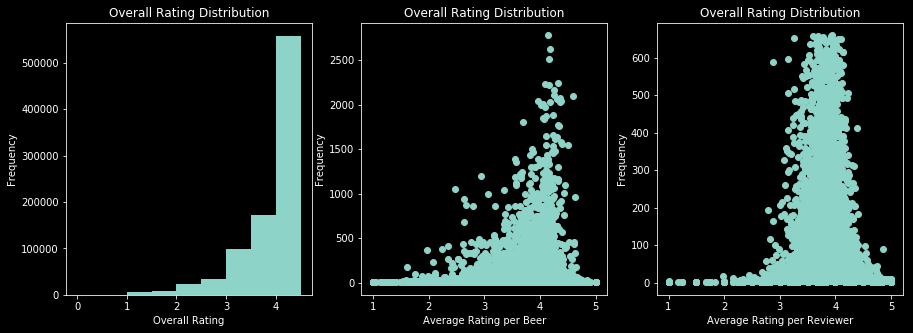

In [0]:
print("Number of BeerIds:",coreData.groupby("beerId").count().shape[0])
print("Number of Reviews:",coreData.shape[0])
print("Number of Reviewers:",len(coreData["ReviewProfileName"].unique()))
print("Average Number of Reviews per BeerId:",int((coreData.groupby("beerId").count().loc[:,"ReviewProfileName"]).mean()))
print("Mean Rating:",round(coreData.groupby("beerId").mean().loc[:,"ReviewOverall"].mean(),2))

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(coreData["ReviewOverall"],bins=list(np.arange(0,5,0.5)))
plt.xlabel("Overall Rating")
plt.ylabel("Frequency")
plt.title("Overall Rating Distribution")

plt.subplot(132)
plt.scatter(coreData.groupby("beerId").mean().loc[:,"ReviewOverall"],
            coreData.groupby("beerId").count().loc[:,"ReviewOverall"])
plt.xlabel("Average Rating per Beer")
plt.ylabel("Frequency")
plt.title("Overall Rating Distribution")

plt.subplot(133)
plt.scatter(coreData.groupby("ReviewProfileName").mean().loc[:,"ReviewOverall"],
            coreData.groupby("ReviewProfileName").count().loc[:,"ReviewOverall"])
plt.xlabel("Average Rating per Reviewer")
plt.ylabel("Frequency")
plt.title("Overall Rating Distribution")
plt.show()


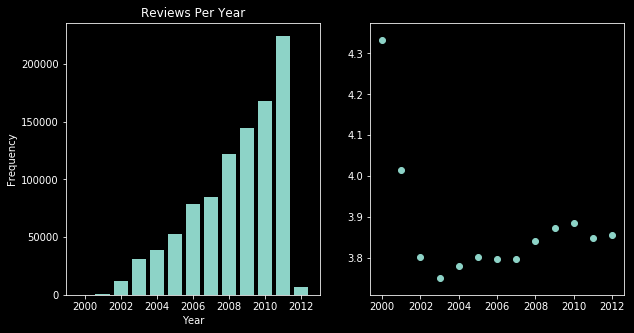

In [0]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.bar(coreData.groupby("RTyear").count().index,coreData.groupby("RTyear").count()["beerId"])
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Reviews Per Year")

plt.subplot(122)
plt.scatter(coreData.groupby("RTyear").count().index,coreData.groupby("RTyear").mean()["ReviewOverall"])

plt.show()

### Remove reviews before 2002

Remove the Reviews before 2002 due to unbalanced ratings and limited number

In [0]:
yearThr = 2002
yearfilter = coreData.groupby("RTyear").count().sort_values(by="beerId", ascending=False)
yearfilter = yearfilter[yearfilter.index>=yearThr]
coreData = coreData[coreData["RTyear"].isin(yearfilter.index)==True]

Threshold: 2002
Number of BeerIds: 45183
Number of Reviews: 965374
Number of Reviewers: 32863
Average Number of Reviews per BeerId: 21
Mean Rating: 3.7


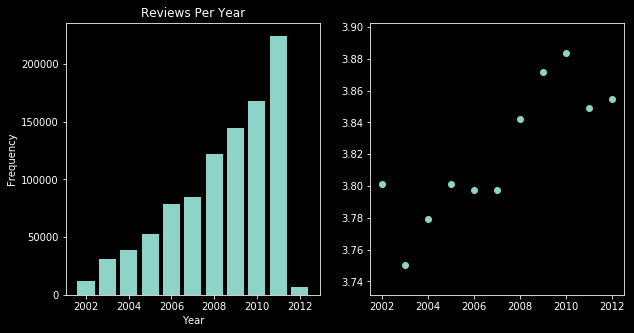

In [0]:
print("Threshold:",yearThr)
print("Number of BeerIds:",coreData.groupby("beerId").count().shape[0])
print("Number of Reviews:",coreData.shape[0])
print("Number of Reviewers:",len(coreData["ReviewProfileName"].unique()))
print("Average Number of Reviews per BeerId:",int((coreData.groupby("beerId").count().loc[:,"ReviewProfileName"]).mean()))
print("Mean Rating:",round(coreData.groupby("beerId").mean().loc[:,"ReviewOverall"].mean(),2))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.bar(coreData.groupby("RTyear").count().index,coreData.groupby("RTyear").count()["beerId"])
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Reviews Per Year")

plt.subplot(122)
plt.scatter(coreData.groupby("RTyear").count().index,coreData.groupby("RTyear").mean()["ReviewOverall"])

plt.show()

### Remove Beers with few reviews

Remove the beerIds which the total number of reviews is less than 30

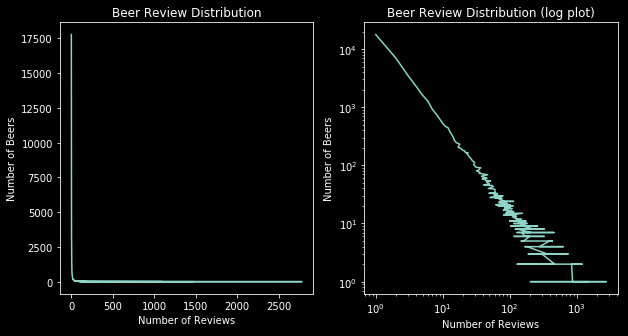

In [0]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(coreData["beerId"].value_counts().value_counts()),
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Beers")
plt.title("Beer Review Distribution")

plt.subplot(122)
plt.loglog(coreData["beerId"].value_counts().value_counts()),
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Beers")
plt.title("Beer Review Distribution (log plot)")
plt.show()

In [0]:
filteroneThr=100 # BeerIds with less than 10 reviews to be eliminated
filterone = coreData.groupby("beerId").count()
filterone = filterone[filterone["ReviewProfileName"]>=filteroneThr]
coreData = coreData[coreData["beerId"].isin(filterone.index)==True]
print("Threshold:",filteroneThr)
print("Number of BeerIds:",coreData.groupby("beerId").count().shape[0])
print("Number of Reviews:",coreData.shape[0])
print("Number of Reviewers:",len(coreData["ReviewProfileName"].unique()))
print("Average Number of Reviews per BeerId:",int((coreData.groupby("beerId").count().loc[:,"ReviewProfileName"]).mean()))
print("Mean Rating:",round(coreData.groupby("beerId").mean().loc[:,"ReviewOverall"].mean(),2))

Threshold: 100
Number of BeerIds: 1949
Number of Reviews: 656466
Number of Reviewers: 28217
Average Number of Reviews per BeerId: 336
Mean Rating: 3.83


### Remove Reviewers with few reviews

Remove the reviewers which has less than 10 reviews

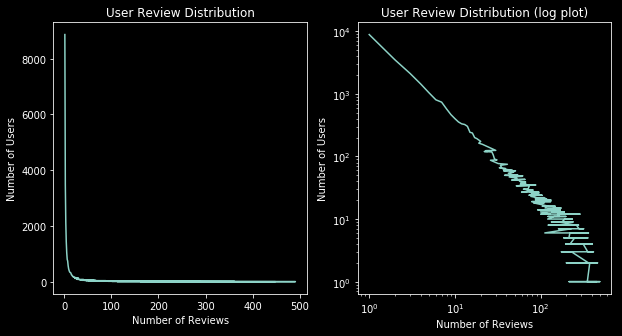

In [0]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(coreData["ReviewProfileName"].value_counts().value_counts())
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Users")
plt.title("User Review Distribution")

plt.subplot(122)
plt.loglog(coreData["ReviewProfileName"].value_counts().value_counts())
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Users")
plt.title("User Review Distribution (log plot)")
plt.show()

In [0]:
rvwThr = 50
spamfilter = coreData.groupby("ReviewProfileName").count().sort_values(by="beerId", ascending=False)
spamfilter = spamfilter[spamfilter["beerId"] > rvwThr]
coreData = coreData[coreData["ReviewProfileName"].isin(spamfilter.index)==True]
print("Threshold:",rvwThr)
print("Number of BeerIds:",coreData.groupby("beerId").count().shape[0])
print("Number of Reviews:",coreData.shape[0])
print("Number of Reviewers:",len(coreData["ReviewProfileName"].unique()))
print("Average Number of Reviews per BeerId:",int((coreData.groupby("beerId").count().loc[:,"ReviewProfileName"]).mean()))
print("Mean Rating:",round(coreData.groupby("beerId").mean().loc[:,"ReviewOverall"].mean(),2))

Threshold: 50
Number of BeerIds: 1949
Number of Reviews: 485978
Number of Reviewers: 3403
Average Number of Reviews per BeerId: 249
Mean Rating: 3.81


### Training - Test Split

In [0]:
print(coreData.shape)
coreData.head(2)

(485978, 15)


,beerName,beerId,brewerId,beerABV,beerStyle,ReviewAppearance,ReviewAroma,ReviewPalate,ReviewTaste,ReviewOverall,ReviewTime,ReviewProfileName,RTadjusted,RTyear,RTmonth
330,Caldera IPA,10784,1075,6.10,American IPA,4.0,4.0,4.0,3.5,4.0,1297129212,Rutager,08/02/2011,2011,2
331,Caldera IPA,10784,1075,6.10,American IPA,4.0,4.0,4.0,4.0,4.5,1297105083,CHILLINDYLAN,07/02/2011,2011,2


In [0]:
testData = coreData[coreData["RTyear"] >= 2011]
coreData = coreData[coreData["RTyear"] < 2011]

### Add Nodes in Bipartite Structure

In [0]:
Bgraph = nx.Graph()
Bgraph.add_nodes_from(list(coreData["beerId"]), bipartite=0)
Bgraph.add_nodes_from(list(coreData["ReviewProfileName"]), bipartite=1)

### Add Weighted Edges (weight = 1)

In [0]:
Bedgelist=[]
for rw in coreData.index:
    temp=(coreData.loc[rw,"beerId"],coreData.loc[rw,"ReviewProfileName"], 1)
    Bedgelist.append(temp)
Bgraph.add_weighted_edges_from(Bedgelist)

In [0]:
count=0
for n in Bgraph.edges(data=True):
    if count <=10:
        print(n)
        count+=1
    else:
        break

(10784, 'lstokes', {'weight': 1})
(10784, 'csiewert', {'weight': 1})
(10784, 'beerphan', {'weight': 1})
(10784, 'climax', {'weight': 1})
(10784, 'AEK', {'weight': 1})
(10784, 'BuckyFresh', {'weight': 1})
(10784, 'SamuelJackson45', {'weight': 1})
(10784, 'djbreezy', {'weight': 1})
(10784, 'DeanMoriarty', {'weight': 1})
(10784, 'Bfarr', {'weight': 1})
(10784, 'Beerenauslese', {'weight': 1})


### Generate Node Lists from Bpartite Graph

In [0]:
beer_nodes = {n for n, d in Bgraph.nodes(data=True) if d['bipartite']==0}
user_nodes = {n for n, d in Bgraph.nodes(data=True) if d['bipartite']==1}

In [0]:
count=0
for n,d in Bgraph.nodes(data=True):
    if count <=10:
        print(n,d)
        count+=1
    else:
        break

10784 {'bipartite': 0}
436 {'bipartite': 0}
37518 {'bipartite': 0}
57110 {'bipartite': 0}
33624 {'bipartite': 0}
52211 {'bipartite': 0}
47695 {'bipartite': 0}
33644 {'bipartite': 0}
29687 {'bipartite': 0}
966 {'bipartite': 0}
962 {'bipartite': 0}


### Generate the Projected Graph (users are projected on beers)

Standard weighted projected graph (weight=number of common reviewers)

In [0]:
Bprojected = bipartite.weighted_projected_graph(Bgraph,nodes=beer_nodes)

### Remove Edges with small weight

In [0]:
edge_list = list(Bprojected.edges())
weight_list = []
remove_edge = []
for i in edge_list:
  edge_weight = Bprojected.get_edge_data(*i)["weight"]
  weight_list.append(edge_weight)
  if edge_weight < 50:
    remove_edge.append(i)
count_dic = Counter(weight_list)

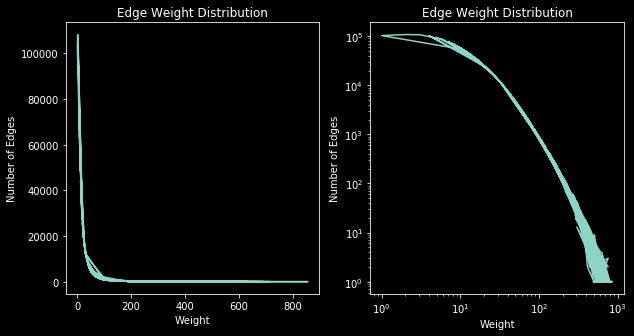

In [0]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(count_dic.keys(),count_dic.values())
plt.xlabel("Weight")
plt.ylabel("Number of Edges")
plt.title("Edge Weight Distribution")

plt.subplot(122)
plt.loglog(count_dic.keys(),count_dic.values())
plt.xlabel("Weight")
plt.ylabel("Number of Edges")
plt.title("Edge Weight Distribution")
plt.show()

In [0]:
Bprojected2 = Bprojected.copy()
Bprojected2.remove_edges_from(remove_edge)

### Normalization

#### Normalization Step1

Weight of an edge divided to total number of reviews of nodes of the edge to adjust edge importances.

Without first step of the normalization, weight of an edge between two nodes with high number of reviews may be larger than weight of an edge between two nodes with smaller number of reviews, but sharing most of their users.

In [0]:
beertotalreviews = coreData.groupby("beerId").count()
beertotalreviews = pd.DataFrame(beertotalreviews["ReviewOverall"])

In [0]:
Bprojected_pairs= list(Bprojected2.edges(data=False))
weightlist=[(x,y,z["weight"]) for x,y,z in list(Bprojected2.edges(data=True))]

In [0]:
totwhtlist = [] #TOTAL REVIEWS OF TWO NODES
for p in Bprojected_pairs:
        p1 = p[0]
        p2 = p[1]
        totwht = beertotalreviews.loc[p1,"ReviewOverall"]+beertotalreviews.loc[p2,"ReviewOverall"]
        totwhtlist.append((p1,p2,totwht))

n1whtlist = []
maxwht=0
for i in range(len(weightlist)):
    n1wht=weightlist[i][2]/totwhtlist[i][2] #NUMBER OF EDGED REVIEWS OF TWO NODES / TOTAL REVIEWS OF TWO NODES
    n1whtlist.append((weightlist[i][0],weightlist[i][1],n1wht))
    if n1wht>maxwht:
        maxwht=n1wht

#### Normalization Step2

All weights are divided to maximum weight of the network to make all edges comparable.

In [0]:
n2whtlist=[]
for item in n1whtlist:
    n2wht=item[2]/maxwht #WEIGHT OF EDGE / MAXIMUM OF "EDGE WEIGHTS IN GRAPH"
    n2whtlist.append((item[0],item[1],n2wht))   

#### Generate Normalized Projected Graph

In [0]:
Bprojected_norm = Bprojected2.copy()
Bprojected_norm.add_weighted_edges_from(n2whtlist)

In [0]:
list(Bprojected_norm.edges(data=True))[:10]

[(5, 6, {'weight': 0.4422337562475971}),
 (5, 7, {'weight': 0.41082802547770697}),
 (5, 30, {'weight': 0.14987325728770592}),
 (5, 33, {'weight': 0.17479674796747965}),
 (5, 34, {'weight': 0.16124561832558895}),
 (5, 39, {'weight': 0.13212881022615536}),
 (5, 61, {'weight': 0.21553884711779447}),
 (5, 63, {'weight': 0.2009993552546744}),
 (5, 65, {'weight': 0.19526039449411098}),
 (5, 73, {'weight': 0.19623731023563376})]

### Network Analysis

In [0]:
print("Number of Connected Components (excluding isolated nodes):", nx.number_connected_components(Bprojected_norm) - nx.number_of_isolates(Bprojected_norm))
print("Number of Isolated Nodes:", nx.number_of_isolates(Bprojected_norm))
largest_cc = max(nx.connected_component_subgraphs(Bprojected_norm), key=len)
print("Number of Nodes in largest CC:", largest_cc.number_of_nodes())
print("Number of Edges in largest CC:", largest_cc.number_of_edges())

avg_degr = 2 * largest_cc.number_of_edges() / float(largest_cc.number_of_nodes())
print("Average Degree:", int(avg_degr))

#print("Average Clustering Coef:", nx.average_clustering(Bprojected_norm))
#print("\nDiameter of the network:", nx.diameter(largest_cc))
#print("Average Shortest Path Length CC:", nx.average_shortest_path_length(largest_cc))

Number of Connected Components (excluding isolated nodes): 1
Number of Isolated Nodes: 306
Number of Nodes in largest CC: 1603
Number of Edges in largest CC: 152295
Average Degree: 190


In [0]:
#Average Clustering Coefficient
print("Average Clustering Coef:", nx.average_clustering(largest_cc))

Average Clustering Coef: 0.8721417676698456


In [0]:
#Average Shortest Path Length in Largest Connected Component
#Commented out due to time complexity.
#print("Average Shortest Path Length CC:", nx.average_shortest_path_length(largest_cc, weight="weight"))

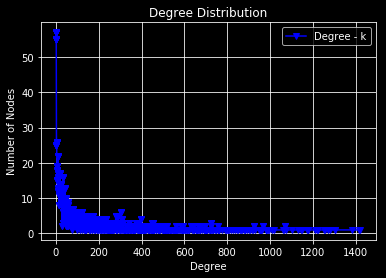

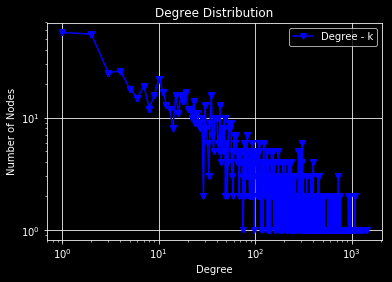

In [0]:
#Degree Distribution Function
def PlotDegreeDistribution(G, loglog=False):
    degree = dict(G.degree())
    values = sorted(list(degree.values()))
    hist = [list(degree.values()).count(x) for x in values]
    plt.figure()
    plt.grid(True)
    if not loglog:
        plt.plot(values, hist, 'bv-')
    else:
        plt.loglog(values, hist, 'bv-')
    plt.legend(['Degree - k'])
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.title('Degree Distribution')
    plt.show()
    
#Degree Distribution
PlotDegreeDistribution(largest_cc, False)
PlotDegreeDistribution(largest_cc, True)

In [0]:
#Graph Drawing
#Commented out due to time complexity.
#nx.draw(Bprojected_norm)
#plt.show()

### Centrality Metrics

In [0]:
#Degree Centrality
sorted(list(largest_cc.degree(weight='weight')), key=lambda tup: tup[1], reverse = True)[:5]

In [0]:
#largest_cc_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in largest_cc.edges(data='weight')}
#nx.set_edge_attributes(largest_cc, largest_cc_distance_dict, 'distance')

In [0]:
#Closeness Centrality
#Commented out due to time complexity.
#clsCent = nx.closeness_centrality(largest_cc, distance="distance")
#clsCentSorted = sorted(clsCent.items(), key=lambda x: x[1], reverse=True)
#clsCentSorted[:5]

### Community

In [0]:
#Louvain Algorithm
partition = community.best_partition(largest_cc)

In [0]:
comm_dict = {}
for k, v in partition.items():
  if v in comm_dict.keys():
    comm_dict[v].append(k)
  else:
     comm_dict[v] = [k]

In [0]:
#Total Number of Communities
len(comm_dict)

9

In [0]:
#Community Sizes
for i in range(len(comm_dict.values())):
  print(len(list(comm_dict.values())[i]))

405
251
737
161
35
5
3
3
3


### Draw Network with Communities

In [0]:
#Commented out due to time complexity.
#values = [partition.get(node) for node in largest_cc.nodes()]
#plt.figure(figsize=(30,40))
#nx.draw_spring(largest_cc, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)

### Beer Similarity - node2vec

In [0]:
#Vectors of nodes calculated with node2vec algorithm
node2vec = Node2Vec(largest_cc, dimensions=64, walk_length=30, num_walks=200, p=0.5, q=2)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [0]:
vectors = model.wv.vectors

In [0]:
largest_cc_nodes = list(largest_cc.nodes())

### Findind Target Audience and Evaluation

In [0]:
#Filtering largest 4 communities
pot_node_list = comm_dict[0] + comm_dict[1] + comm_dict[2] + comm_dict[3]
len(pot_node_list)

1554

In [0]:
#List of all target beer brands
target_node_list = []
for i in pot_node_list:
  core_num = coreData[coreData["beerId"] == i].shape[0]
  test_num = testData[testData["beerId"] == i].shape[0]
  if core_num >= 100 and test_num >=20:
    target_node_list.append(i)

len(target_node_list)

943

In [0]:
#Calculating vector similarities with cosine similarity and finding most similar 50 nodes for each node
#Calculating average ratings of all beer brands and average of ratings given by selected users as target audience for each node
selected_avg_list = []
real_avg_list = []
total_rating_list = []
selected_user_num = []
real_user_num = []
#Community filter for node
for i in target_node_list:
  comm_list = comm_dict[partition[i]]
  idx1 = largest_cc_nodes.index(i)
  
  #Selecting most similar 50 nodes with cosine similarity in the community of target node.
  result_list = []
  for j in range(len(comm_list)):
    if i != comm_list[j]:
      idx2 = largest_cc_nodes.index(comm_list[j])
      result = 1 - spatial.distance.cosine(vectors[idx1], vectors[idx2])
      result_list.append((comm_list[j], result))

  result_list.sort(key = operator.itemgetter(1), reverse = True)
  sorted_list = result_list[:50]

  final_node_list = []
  for tpl in sorted_list:
    final_node_list.append(tpl[0])
    
  #Filter top 20 users for each similar node (50 for each target node - calculated above)
  #And filter users with at least 4.5 rating for similar node.
  total_rating = []
  total_user = []
  for node in final_node_list:
    coreData2 = coreData[coreData["beerId"] == node].sort_values("ReviewOverall", ascending = False)
    coreData2 = coreData2[coreData2["ReviewOverall"] >= 4.5].head(20)
    user_list = list(coreData2["ReviewProfileName"])
    rating_list = testData[testData["beerId"] == i][testData["ReviewProfileName"].isin(user_list)]["ReviewOverall"]
    rating_sum = sum(rating_list)
    if rating_sum != 0:
      num_user = len(rating_list)
      total_rating.append(rating_sum)
      total_user.append(num_user)
    
  #Calculating average ratings
  if sum(total_user) != 0:
    selected_avg = sum(total_rating) / sum(total_user)
    real_avg = testData[testData["beerId"] == i]["ReviewOverall"].mean()
    selected_avg_list.append(selected_avg)
    real_avg_list.append(real_avg)
    total_rating_list.append(sum(total_rating))
    selected_user_num.append(sum(total_user))
    real_user_num.append(testData[testData["beerId"] == i].shape[0])
  

In [0]:
coreData[coreData["beerId"] == node].sort_values("ReviewOverall", ascending = False)[coreData["ReviewOverall"] >= 4.5].head(20)["ReviewProfileName"]

In [0]:
total_sum = 0
for i in range(len(selected_avg_list)):
  total_sum += (selected_avg_list[i] * selected_user_num[i])
  
avg = total_sum / sum(selected_user_num)

In [0]:
#Average of ratings of target audiences for all nodes
avg

3.9751710826460784

In [0]:
#Average rating of dataset excluding ratings given by users selected for target audience for a brand
avg_rating_exc_list = []
for i in range(len(real_avg_list)):
  real_total_rating = real_avg_list[i] * real_user_num[i]
  real_total_rating = real_total_rating - total_rating_list[i]
  if (real_user_num[i] - selected_user_num[i]) != 0:
    avg_rating_exc = real_total_rating / (real_user_num[i] - selected_user_num[i])
    avg_rating_exc_list.append(avg_rating_exc)
  else:
    avg_rating_exc_list.append(np.nan)
    
np.nanmean(avg_rating_exc_list)

3.7834909881611725

In [0]:
#Percentage increase in average rating
sum(selected_user_num) / sum(real_user_num)

0.16486345753297849

In [0]:
#Number of brands of which target audience has higher avg rating than overall rating (out of 943)
count = 0
for i in range(len(avg_rating_exc_list)):
  if avg_rating_exc_list[i] != np.nan:
    if avg_rating_exc_list[i] < selected_avg_list[i]:
      count += 1
      
count

606

In [0]:
#Beer brand examples:
#Heineken Lager Beer, Budweiser Budvar, Leffe Blond, Corona Extra, Duvel
sample_list = [246, 6715, 2137, 232, 695]

sample_dict = dict.fromkeys(sample_list, [])
sample_dict

{232: [], 246: [], 695: [], 2137: [], 6715: []}

In [0]:
#Selecting target audiences for 5 brands
for i in sample_list:
  comm_list = comm_dict[partition[i]]
  idx1 = largest_cc_nodes.index(i)
  
  result_list = []
  for j in range(len(comm_list)):
    if i != comm_list[j]:
      idx2 = largest_cc_nodes.index(comm_list[j])
      result = 1 - spatial.distance.cosine(vectors[idx1], vectors[idx2])
      result_list.append((comm_list[j], result))

  result_list.sort(key = operator.itemgetter(1), reverse = True)
  sorted_list = result_list[:50]

  final_node_list = []
  for tpl in sorted_list:
    final_node_list.append(tpl[0])

  total_rating = []
  total_user_list2 = []
  for node in final_node_list:
    coreData2 = coreData[coreData["beerId"] == node].sort_values("ReviewOverall", ascending = False)
    coreData2 = coreData2[coreData2["ReviewOverall"] >= 4.5].head(20)
    user_list = list(coreData2["ReviewProfileName"])
    user_list2 = list(testData[testData["beerId"] == i]["ReviewProfileName"])
    user_list_final = []
    for user in user_list:
      if user not in user_list2:
        user_list_final.append(user)
    total_user_list2 = total_user_list2 + user_list_final
  
  sample_dict[i] = sample_dict[i] + total_user_list2 
  

In [0]:
#Target Audience Sizes for 5 brands
for i in  sample_list:
  print(len(np.unique(sample_dict[i])))

598
514
484
587
666


In [0]:
#Usernames of Target Audience of Heineken Lager Beer (commented out due to high number of user recommendation)
#sample_dict[232]